In [1]:
import numpy as np
import pandas as pd
from glob import glob
from scipy import signal

size = 832
files = glob('Z:\Descargas\composite\CSV_DATA\*.csv')
for file in files:
    df = pd.read_csv(file)
    col_names = ('Flow rate', 'Pressure')    
    cols = [col for col in df if col.endswith(col_names)]  
    new_df = df[cols].head(size)
    new_df['TOTAL_QUALITY'] = df['TOTAL_QUALITY'].head(size)
    new_df.to_csv(file.replace('CSV_DATA', 'test\CSV_DATA_RESAMPLED'), index=False)

In [2]:
import numpy as np
import pandas as pd
from glob import glob

files = glob('Z:\\Descargas\\composite\\test\\CSV_DATA_RESAMPLED\\*.csv')

correct = []
incorrect = []

for file in files:
    df = pd.read_csv(file)
    if df.iloc[:,-1][0] == 1:
        correct.append(df)
    else:
        incorrect.append(df)
        
print(len(correct))
print(len(incorrect))

5055
4959


In [3]:
train_correct = correct[:4000]
train_correct = pd.concat(train_correct)
train_correct = train_correct.to_csv('Z:\\Descargas\\composite\\test\\train_correct.csv', index=False)

test_correct = correct[-1055:]
test_correct = pd.concat(test_correct)
test_correct = test_correct.to_csv('Z:\\Descargas\\composite\\test\\test_correct.csv', index=False)

test_incorrect = incorrect
test_incorrect = pd.concat(test_incorrect)
test_incorrect = test_incorrect.to_csv('Z:\\Descargas\\composite\\test\\test_incorrect.csv', index=False)

In [4]:
import pandas as pd

train = pd.read_csv('Z:\\Descargas\\composite\\test\\train_correct.csv')
train = train.drop('TOTAL_QUALITY', axis=1)
train.shape

(3328000, 29)

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(train)
train = scaler.transform(train)
train.shape

(3328000, 29)

In [6]:
# reshape input into [samples, timesteps, features]

train = train.reshape((4000, 832, 29))
train.shape

(4000, 832, 29)

In [14]:
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l1, l2

model = models.Sequential([
    layers.LSTM(128, activation='relu', return_sequences=True, input_shape=(832, 29)),
    layers.LSTM(64, activation='relu', return_sequences=False),
    layers.RepeatVector(train.shape[1]),
    layers.LSTM(64, activation='relu', return_sequences=True),
    layers.LSTM(128, activation='relu', return_sequences=True),
    layers.TimeDistributed(layers.Dense(train.shape[2]))
])

opt = SGD(lr=0.01, momentum=0.9, nesterov=True, clipnorm=1)
model.compile(optimizer=opt, loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 832, 128)          80896     
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                49408     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 832, 64)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 832, 64)           33024     
_________________________________________________________________
lstm_15 (LSTM)               (None, 832, 128)          98816     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 832, 29)           3741      
Total params: 265,885
Trainable params: 265,885
Non-trainable params: 0
________________________________________________

In [15]:
early_stop = [EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto', baseline=None)]

history = model.fit(train, train, callbacks=early_stop, epochs=20, batch_size=128, validation_split=0.1)

Train on 3600 samples, validate on 400 samples
Epoch 1/20
3600/3600 [==============================] - 56s 16ms/sample - loss: 0.0611 - val_loss: 0.0354
Epoch 2/20
3600/3600 [==============================] - 54s 15ms/sample - loss: 0.0466 - val_loss: 0.0265
Epoch 3/20
3600/3600 [==============================] - 54s 15ms/sample - loss: 0.0376 - val_loss: 0.0223
Epoch 4/20
3600/3600 [==============================] - 53s 15ms/sample - loss: 0.0327 - val_loss: 0.0205
Epoch 5/20
3600/3600 [==============================] - 54s 15ms/sample - loss: 0.0303 - val_loss: 0.0199
Epoch 6/20
3600/3600 [==============================] - 54s 15ms/sample - loss: 0.0291 - val_loss: 0.0198
Epoch 7/20
3600/3600 [==============================] - 55s 15ms/sample - loss: 0.0285 - val_loss: 0.0199
Epoch 8/20
3600/3600 [==============================] - 55s 15ms/sample - loss: 0.0282 - val_loss: 0.0200
Epoch 9/20
3600/3600 [==============================] - 55s 15ms/sample - loss: 0.0281 - val_loss: 0.0201

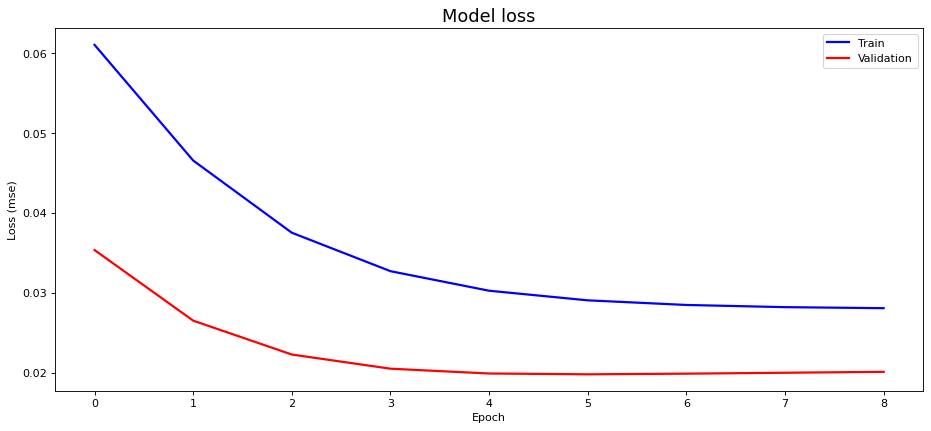

In [16]:
from matplotlib import pyplot as plt

# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mse)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [17]:
model.save('models/lstm_autoencoder_model_test.h5') 

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('models/lstm_autoencoder_model_test.h5')
model.summary()

In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# load
train = pd.read_csv('Z:\\Descargas\\composite\\test\\train_correct.csv')
train = train.drop('TOTAL_QUALITY', axis=1)
test_incorrect = pd.read_csv('Z:\\Descargas\\composite\\test\\test_incorrect.csv')
test_incorrect = test_incorrect.drop('TOTAL_QUALITY', axis=1)

# normalize
scaler = MinMaxScaler().fit(train)
train = scaler.transform(train)
test_incorrect = scaler.transform(test_incorrect)

# reshape
train = train.reshape((4000, 832, 29))
test_incorrect = test_incorrect.reshape((4959, 832, 29))

# predict
pred_train = model.predict(train)
pred_test = model.predict(test_incorrect)
pred_train.shape

(4000, 832, 29)

In [19]:
import numpy as np

train_loss = np.mean(np.abs(pred_train-train), axis=2)
train_loss = np.mean(train_loss, axis=1)
threshold = train_loss.mean()+3*train_loss.std()
threshold

0.17861725687773738

In [20]:
draw_train = np.mean(np.abs(pred_train-train), axis=2)
draw_train = np.mean(draw_train, axis=1)

draw_test = np.mean(np.abs(pred_test-test_incorrect), axis=2)
draw_test = np.mean(draw_test, axis=1)

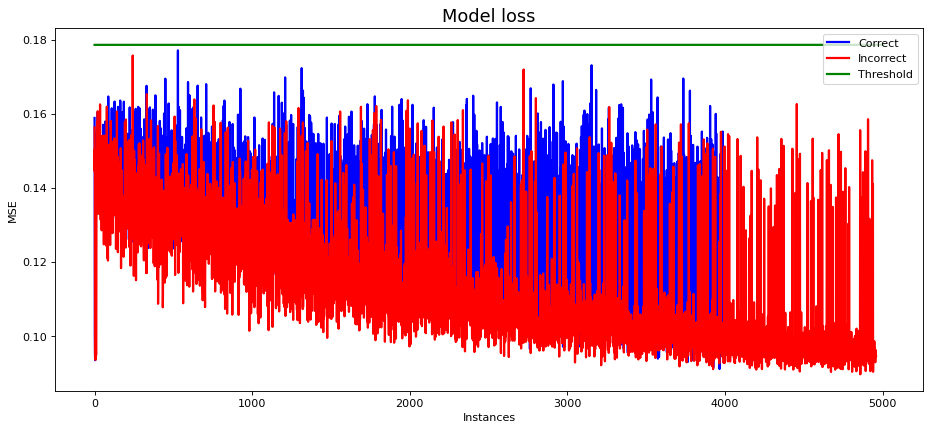

In [21]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(draw_train, 'b', label='Correct', linewidth=2)
ax.plot(draw_test, 'r', label='Incorrect', linewidth=2)
ax.plot(np.full(shape=5007, fill_value=threshold), 'g', label='Threshold', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('MSE')
ax.set_xlabel('Instances')
ax.legend(loc='upper right')
plt.show()